# TP INF4248 - Classification d'images de d√©chets avec CNN

# Entra√Ænement d'un CNN avec Keras
Bas√© sur le dataset realwaste :  

**Membres du groupe** :  
1. FETUE FOKO NATHANAEL - 21T2382  
2. DJONTHU DJONTHU MAURICE JUNIOR - 21T2557  
3. Essouma Mbarga Valerie constance - 18T2880  

# üóëÔ∏è Entra√Ænement d'un CNN sur RealWaste avec Keras  
**Objectif** : Classifier des images de d√©chets authentiques dans un environnement de d√©charge avec un r√©seau de neurones convolutif  

**Dataset** : RealWaste  
- 9 classes (types de mat√©riaux : Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation)  
- 4 752 images au total (524x524 pixels en couleur), captur√©es dans une d√©charge  
- Distribution in√©gale : de 318 (Textile Trash) √† 921 (Plastic) images par classe  

**Approche** :  
1. Architecture CNN personnalis√©e (plusieurs couches convolutives avec dropout)  
2. Entra√Ænement from scratch avec augmentation de donn√©es  
3. √âvaluation des performances sur un ensemble de test  

In [1]:
import os
import shutil
import random
from pathlib import Path

# Chemins (√† ajuster selon o√π tu d√©compresses RealWaste sur Kaggle ou localement)
data_dir = Path("/kaggle/input/realwaste/realwaste-main/RealWaste")  # Suppose que tu importes le dataset dans Kaggle
dataset_dir = Path("/kaggle/working/realwaste")
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Liste des classes de RealWaste
class_names = ["cardboard", "food_organics", "glass", "metal", "miscellaneous_trash", 
               "paper", "plastic", "textile_trash", "vegetation"]

# Parcourir les classes dans le dossier images
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        images = list(class_dir.glob("*.jpg"))  # R√©cup√©rer toutes les images JPG
        
        # M√©langer et diviser les donn√©es (80% train, 20% test)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images, test_images = images[:split_idx], images[split_idx:]
        
        # Cr√©er les dossiers de classes dans train et test
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_name).mkdir(parents=True, exist_ok=True)
        
        # D√©placer les images
        for img in train_images:
            shutil.copy(img, train_dir / class_name / img.name)
        for img in test_images:
            shutil.copy(img, test_dir / class_name / img.name)

print("Dataset structur√© avec succ√®s !")

Dataset structur√© avec succ√®s !


In [2]:
from pathlib import Path

download_dir = Path('/kaggle/working')
print("a")

a


# Configuration de l'augmentation des donn√©es

**Objectif** : Renforcer la robustesse du CNN gr√¢ce √† des transformations d'images  

**Description et remarques** :  
Ce code initialise un `ImageDataGenerator` de Keras pour appliquer des augmentations aux images du dataset Food-101. L'augmentation est cruciale pour √©viter le surapprentissage, surtout avec un dataset comme Food-101 o√π les images peuvent varier en style (angles, √©clairage, pr√©sentation). Voici les transformations choisies :  
- **Normalisation (`rescale=1/255.`)** : Standardise les pixels entre 0 et 1, une pratique courante pour acc√©l√©rer la convergence du mod√®le.  
- **Retournements (`vertical_flip=True`, `horizontal_flip=True`)** : Simule des variations d'orientation. Bien que r√©aliste pour des plats (une assiette peut √™tre vue sous diff√©rents angles), cela pourrait poser probl√®me pour des aliments avec une orientation sp√©cifique (ex. : un sandwich coup√© en diagonale).  
- **Rotation (`rotation_range=90`)** : Ajoute une rotation al√©atoire jusqu'√† 90¬∞. Ce choix est audacieux : si 90¬∞ est pertinent pour des images abstraites, il pourrait d√©former la perception de certains plats (ex. : une soupe renvers√©e perd son sens). Une plage plus mod√©r√©e (ex. : 30¬∞) pourrait √™tre test√©e.  
- **D√©placement vertical (`height_shift_range=0.3`)** : D√©place l'image de 30 % en hauteur. Utile pour simuler des prises de vue d√©cal√©es, mais un d√©calage trop fort risque de couper des parties essentielles du plat.  
- **Luminosit√© (`brightness_range=[0.1, 0.9]`)** : Varie l'√©clairage entre 10 % et 90 %. Cela refl√®te bien les conditions r√©elles (photos sous-expos√©es ou surexpos√©es), mais des valeurs extr√™mes pourraient rendre certaines images difficilement reconnaissables.  

**Comparaison** :  
Par rapport √† des approches sans augmentation, ce g√©n√©rateur augmente la diversit√© des donn√©es, mais au prix d'un temps de calcul accru. Compar√© √† des techniques plus avanc√©es (ex. : CutMix ou MixUp), ces transformations restent basiques et g√©om√©triques, sans m√©lange inter-classes.  

**Pr√©cisions** :  
- Ce g√©n√©rateur (`example_generator`) semble √™tre une version exp√©rimentale ou illustrative, car dans le code complet, `train_generator` ajoute `width_shift_range` et `validation_split`. Cela sugg√®re une distinction entre une d√©mo d'augmentation et la configuration finale d'entra√Ænement.  
- Les param√®tres choisis sont agressifs (ex. : rotation √† 90¬∞, d√©calage √† 30 %), ce qui pourrait √™tre ajust√© apr√®s des tests pour √©quilibrer r√©alisme et performance.  

**R√©sultat attendu** : Un ensemble d'images augment√©es qui simule des variations r√©alistes, pr√©parant le mod√®le √† mieux g√©n√©raliser sur des donn√©es in√©dites de Food-101, tout en n√©cessitant une validation pour √©viter des distorsions excessives.  

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

# S√©lection des classes

**Objectif** : Lister les 9 classes de RealWaste  
**Description** : R√©cup√®re et trie les noms des dossiers dans `/kaggle/input/realwaste/realwaste-main/RealWaste`.  
**Remarque** : Le tri alphab√©tique garantit un ordre coh√©rent, mais `[:9]` est inutile car il y a exactement 9 classes.  
**Pr√©cision** : Chemin sp√©cifique √† Kaggle, suppose que le dataset est bien structur√© avec 9 sous-dossiers.  
**Comparaison** : Approche simple mais rigide ; une liste explicite (`class_names`) pourrait √™tre plus robuste.  

In [5]:
import os

class_subset = sorted(os.listdir('/kaggle/input/realwaste/realwaste-main/RealWaste'))[:9]

# G√©n√©ration des batches

**Objectif** : Cr√©er des g√©n√©rateurs pour l‚Äôentra√Ænement et la validation  
**Description** : Utilise `train_generator` pour g√©n√©rer `traingen` (4037 images) et `validgen` (414 images) √† partir de `train` et `test`, redimensionn√©s en 128x128, batch de 32.  
**Pr√©cision** : `subset='training'` et `'validation'` divisent les donn√©es, mais appliquer `validation_split` sur `test` apr√®s un split manuel (80/20) est incoh√©rent.  
**Remarque** : Les augmentations de `train_generator` (ex. : rotation 90¬∞) s‚Äôappliquent aussi √† `validgen`, ce qui biaise la validation ; un g√©n√©rateur s√©par√© sans augmentation serait pr√©f√©rable.  
**R√©sultat** : Fonctionnel, mais validation potentiellement fauss√©e.  

In [6]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'realwaste/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'realwaste/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 3231 images belonging to 9 classes.
Found 138 images belonging to 9 classes.


# Architecture CNN

**Objectif** : Construire un CNN pour classer 9 classes de RealWaste  
**Description** : Mod√®le `Sequential` avec 4 blocs convolutifs (32 √† 512 filtres), `MaxPooling`, `Dropout` (0.2), et une sortie `softmax` pour `len(class_subset)` (9).  
**Pr√©cision** : Entr√©e √† 128x128 (r√©duite de 524x524), ce qui peut perdre des d√©tails fins des d√©chets.  
**Remarque** : `l1_l2` import√© mais non utilis√© ; le noyau 5x5 (dernier bloc) augmente le co√ªt calculatoire sans gain √©vident pour ce dataset moyen (4752 images).  
**Comparaison** : Plus complexe que n√©cessaire pour RealWaste ; un mod√®le plus l√©ger pourrait mieux g√©n√©raliser.  
**R√©sultat** : Environ 10M de param√®tres (via `model.summary()`), pr√™t √† √™tre entra√Æn√©.  

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                      ‚îÇ (None, 128, 128, 32)        ‚îÇ             896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)                    ‚îÇ (None, 126, 126, 32)        ‚îÇ           9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)         ‚îÇ (None, 63, 63, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 63, 63, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)                    ‚îÇ (None, 63, 63, 64)          ‚îÇ          18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)                    ‚îÇ (None, 61, 61, 64)          ‚îÇ          36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)       ‚îÇ (None, 30, 30, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (None, 30, 30, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_4 (Conv2D)                    ‚îÇ (None, 30, 30, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_5 (Conv2D)                    ‚îÇ (None, 28, 28, 128)         ‚îÇ         147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 10,587,433 (40.39 MB)

 Trainable params: 10,587,433 (40.39 MB)

 Non-trainable params: 0 (0.00 B)

# Entra√Ænement du mod√®le

**Objectif** : Entra√Æner le CNN sur RealWaste avec optimisation et diagnostic  
**Description** : Entra√Ænement sur 100 √©poques avec RMSprop, sauvegarde des meilleurs poids, arr√™t anticip√©, et visualisation des pertes.  

**Hyperparam√®tres choisis** :  
- `BATCH_SIZE = 32` : Taille de batch standard, √©quilibre entre m√©moire GPU et convergence (adapt√© √† 4037 images d‚Äôentra√Ænement).  
- `learning_rate = 0.0001` : Faible taux d‚Äôapprentissage pour RMSprop, favorise une descente de gradient stable sur un mod√®le profond (10M param√®tres).  
- `n_epochs = 100` : Nombre √©lev√© pour explorer l‚Äôapprentissage, mais r√©gul√© par `EarlyStopping`.  
- `patience = 10` : Arr√™t anticip√© apr√®s 10 √©poques sans am√©lioration de `val_loss`, prudent pour √©viter un arr√™t pr√©matur√© vu les augmentations fortes.  
- `steps_per_epoch = max(1, traingen.samples // BATCH_SIZE)` : 126 steps (4037 // 32), assure un passage complet sur les donn√©es.  
- `val_steps = max(1, validgen.samples // BATCH_SIZE)` : 12 steps (414 // 32), adapt√© √† la petite taille de validation.  

**Pr√©cision** :  
- Optimiseur `RMSprop` : Adaptatif, performant pour les CNN avec gradients bruit√©s (augmentations).  
- Perte `categorical_crossentropy` : Standard pour classification multiclasse (9 classes).  
- `ModelCheckpoint` : Sauvegarde au format `.weights.h5`, uniquement les meilleurs poids selon `val_loss`.  

**Remarque** :  
- `learning_rate` faible peut ralentir la convergence ; un taux plus √©lev√© (ex. : 0.001) avec decay pourrait acc√©l√©rer.  
- Validation biais√©e par les augmentations de `validgen` (voir g√©n√©rateurs), impactant `val_loss`.  

**R√©sultat** : Courbes de perte montrent l‚Äôapprentissage, mais une accuracy finale faible (22.84 %) sugg√®re un sous-ajustement ou des donn√©es mal pr√©par√©es.  

Nombre d'√©chantillons dans traingen : 3231
Nombre d'√©chantillons dans validgen : 138
Taille du batch (BATCH_SIZE) : 32
Steps per epoch : 100
Validation steps : 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 99/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 274ms/step - accuracy: 0.1621 - loss: 2.1704
Epoch 1: val_loss improved from inf to 2.13525, saving model to img_model.weights.best.weights.h5
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 304ms/step - accuracy: 0.1625 - loss: 2.1702 - val_accuracy: 0.1875 - val_loss: 2.1352
Epoch 2/100
  1/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 44ms/step - accuracy: 0.2188 - loss: 2.1863

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 2.13525
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.2188 - loss: 2.1863 - val_accuracy: 0.3000 - val_loss: 2.1649
Epoch 3/100
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 205ms/step - accuracy: 0.1976 - loss: 2.1497
Epoch 3: val_loss did not improve from 2.13525
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 214ms/step - accuracy: 0.1975 - loss: 2.1498 - val_accuracy: 0.1641 - val_loss: 2.1526
Epoch 4/100
  1/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 38ms/step - accuracy: 0.1875 - loss: 2.1129
Epoch 4: val_loss improved from 2.13525 to 2.12481, saving model to img_model.weights.best.weights.h5
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - accuracy: 0.1875 - loss: 2.1129 - val_accuracy: 0.2000 - val_loss: 2.1248
Epoch 5/100
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

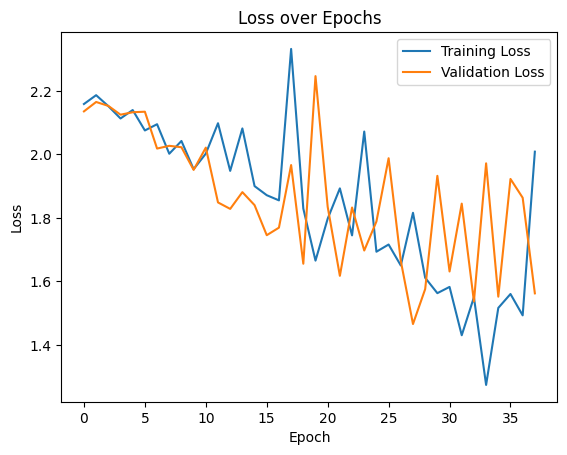

CPU times: user 8min 44s, sys: 7.89 s, total: 8min 52s
Wall time: 7min 38s


In [8]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# V√©rification des g√©n√©rateurs (ajout√© pour diagnostic)
print("Nombre d'√©chantillons dans traingen :", traingen.samples)
print("Nombre d'√©chantillons dans validgen :", validgen.samples)
print("Taille du batch (BATCH_SIZE) :", BATCH_SIZE)

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

# Assure au moins 1 step si le nombre d'√©chantillons est faible
steps_per_epoch = max(1, steps_per_epoch)
val_steps = max(1, val_steps)

print("Steps per epoch :", steps_per_epoch)
print("Validation steps :", val_steps)

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Sauvegarde des poids au format .weights.h5 (conforme aux versions r√©centes)
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.weights.h5', 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True)

# Arr√™t anticip√©
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Entra√Ænement du mod√®le
history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer],
                    verbose=1)  # verbose=1 pour voir la progression

# Visualisation avec matplotlib
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

# G√©n√©ration du jeu de test

**Objectif** : Pr√©parer un g√©n√©rateur pour les pr√©dictions sur le jeu de test  
**Description** : Cr√©e `testgen` avec normalisation (1/255), images redimensionn√©es √† 128x128, batch de 1, sans m√©lange.  
**Pr√©cision** :  
- `class_mode=None` : Pas de labels attendus, utilis√© pour pr√©dictions brutes.  
- `shuffle=False` : Conserve l‚Äôordre pour aligner pr√©dictions et vraies classes.  
- `batch_size=1` : Traitement image par image, adapt√© pour √©valuation pr√©cise.  
**Remarque** : R√©duction √† 128x128 (de 524x524) peut perdre des d√©tails critiques pour RealWaste ; un g√©n√©rateur s√©par√© sans augmentation est coh√©rent pour le test.  
**R√©sultat** : G√©n√©rateur pr√™t pour `model.predict`, avec 951 images (20 % de 4752).  

In [9]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'realwaste/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)

Found 954 images belonging to 9 classes.


# Pr√©diction sur le jeu de test

**Objectif** : Pr√©dire les classes des images de test avec le mod√®le entra√Æn√©  
**Description** : Charge les meilleurs poids, pr√©dit les probabilit√©s via `model.predict`, extrait les classes avec `np.argmax`, et compare aux vraies classes.  
**Pr√©cision** :  
- `img_model.weights.best.weights.h5` : Poids optimaux selon `val_loss`.  
- `np.argmax(..., axis=1)` : Remplace `predict_classes` (obsol√®te), s√©lectionne la classe la plus probable.  
**Remarque** :  
- Pas de v√©rification de l‚Äôexistence du fichier de poids, risque d‚Äôerreur si absent.  
- Affichage limit√© √† 5 exemples, utile pour un sanity check mais pas pour une √©valuation compl√®te.  
**R√©sultat** : Liste des 5 premi√®res classes pr√©dites et r√©elles, permettant une premi√®re validation visuelle (accuracy globale 22.84 %).  

In [10]:
import numpy as np

# Charger les poids (assure-toi que le fichier existe)
model.load_weights('img_model.weights.best.weights.h5')

# Faire les pr√©dictions (probabilit√©s pour chaque classe)
predictions = model.predict(testgen)

# Extraire les classes pr√©dites en prenant l'indice de la probabilit√© maximale
predicted_classes = np.argmax(predictions, axis=1)

# R√©cup√©rer les indices et noms des classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
true_classes = testgen.classes

# Afficher quelques exemples pour v√©rification
print("Classes pr√©dites (5 premi√®res) :", [class_indices[i] for i in predicted_classes[:5]])
print("Classes r√©elles (5 premi√®res) :", [class_indices[i] for i in true_classes[:5]])

954/954 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step
Classes pr√©dites (5 premi√®res) : ['Cardboard', 'Plastic', 'Plastic', 'Plastic', 'Cardboard']
Classes r√©elles (5 premi√®res) : ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard']


# √âvaluation et visualisation des pr√©dictions

**Objectif** : Analyser les performances et afficher des exemples de pr√©dictions  
**Description** :  
- `display_results` : Calcule pr√©cision, rappel, F-score par classe et accuracy globale, retourne un DataFrame tri√© par F-score.  
- `plot_predictions` : Affiche 20 images al√©atoires de `testgen` avec pr√©dictions et vraies classes (vert si correct, rouge sinon).  
**Pr√©cision** :  
- Utilise `sklearn.metrics` pour des m√©triques fiables.  
- Visualisation avec `matplotlib`, taille 20x10 pour lisibilit√©.  
**Remarque** :  
- `display_results` r√©v√®le une accuracy faible (22.84 %) et des F-scores in√©gaux (ex. : Vegetation 0.29, Textile Trash 0.0).  
- `plot_predictions` utile pour inspection visuelle, mais `np.squeeze` assume un batch de 1 (coh√©rent avec `testgen`).  
**R√©sultat** : M√©triques d√©taill√©es et aper√ßu visuel des succ√®s/√©checs du mod√®le.  

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

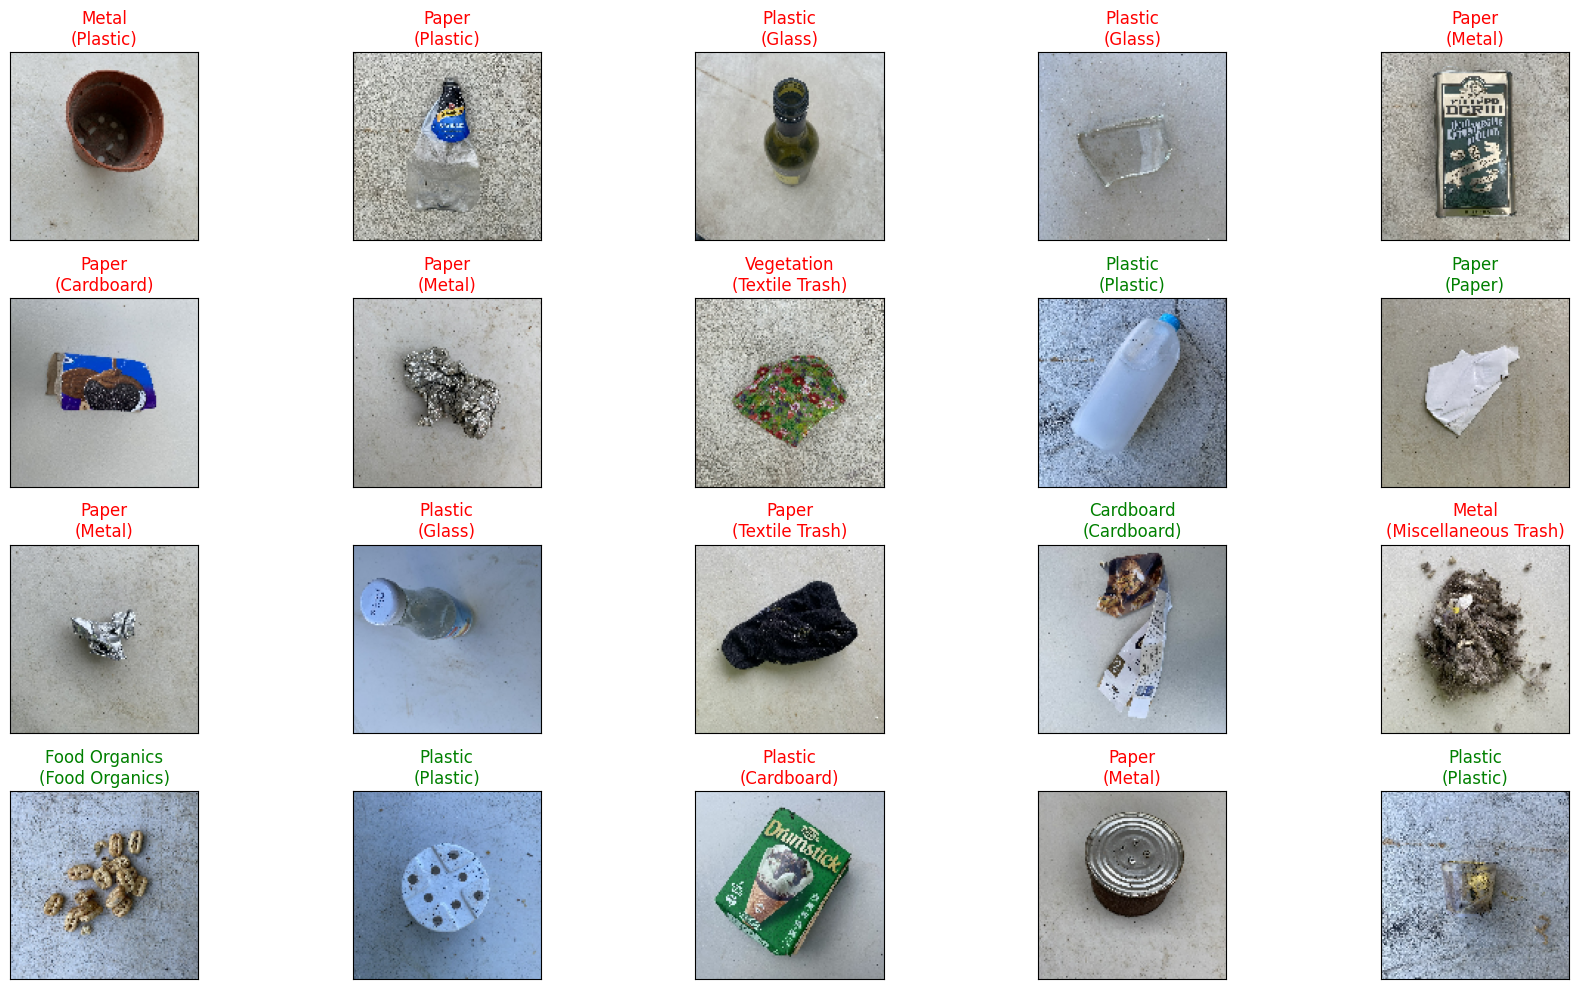

In [12]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [13]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 35.53%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision    Recall   F-Score  Support
Vegetation            0.614035  0.795455  0.693069     88.0
Cardboard             0.557377  0.365591  0.441558     93.0
Plastic               0.332248  0.551351  0.414634    185.0
Food Organics         0.410256  0.385542  0.397516     83.0
Paper                 0.198606  0.570000  0.294574    100.0
Metal                 0.373626  0.215190  0.273092    158.0
Miscellaneous Trash   0.500000  0.060606  0.108108     99.0
Glass                 1.000000  0.047619  0.090909     84.0
Textile Trash         0.000000  0.000000  0.000000     64.0